## Prevendo o valor de Fechamento de Ações do Yahoo!

---



Nessa etapa da primeira atividade faremos a análise da série considerada mais complexa (ou não tão bem comportada).

Esta série é dada pelo histórico dos valores das ações do Yahoo na bolsa de valores americana.

Está disponível no Kaggle no link: https://www.kaggle.com/datasets/arashnic/time-series-forecasting-with-yahoo-stock-price

Para fins de análise utilizaremos os valores de fechamento das ações, geralmente usados nas atividades de trade.

A primeira etapa é proceder com as importações das bibliotecas necessárias para o desenvolvimento do projeto.

Caso não tenha o statsmodels instalando pode usar o comando de temrminal: `pip install statsmodels`

In [1]:
import numpy as np
import pandas as pd
from pandas import Series
import matplotlib.pyplot as plt
from statsmodels.stats.stattools import jarque_bera

#Libs com os modelos de previsao
import statsmodels.api as sm
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

#Ignorar as Warnings do Codigo
import warnings
warnings.filterwarnings("ignore")

A função abaixo constrói e calibra um modelo de previsão de séries temporais conhecida como ETS. Um modelo de suavização exponencial muito utilizado na indústria e no âmbito acadêmico.

As funções e parâmetros utilizados são definidos pela biblioteca statsmodels e podemos encontrar um guia completo para o seu entendimento no link:

https://www.statsmodels.org/dev/examples/notebooks/generated/ets.html

Os parâmetros centrais serão encontrados através da análise da própria série temporal. Outros parâmetros, considerados importantes para uma boa previsão, serão testados através do uso desta função.

A função aqui definida tem como parâmetros a própria série temporal, uma lista de parâmetros e o intervalo de previsão (setamos como 15 para este ensaio).

In [2]:
def previsao_ets(desp_serie, intervalo, parametros):

    error = parametros[0]
    trend = parametros[1]
    seasonal = parametros[2]
    initialization = parametros[3]
    seasonal_periods = parametros[4]

    arr_real =[]
    inter_real = []

    for i in range(intervalo):
        max_size = max(desp_serie.index)
        arr_real.append(desp_serie[max_size])
        inter_real.append(max_size)
        desp_serie = desp_serie.drop(max_size)

    model = ETSModel(desp_serie, error=error, trend=trend, seasonal=seasonal,
                     initialization_method=initialization, seasonal_periods=seasonal_periods)
    model_fit = model.fit(disp=0)

    start = len(desp_serie)
    end = len(desp_serie)+intervalo-1

    previsto = model_fit.predict(start = start, end = end)
    serie_real = Series(arr_real, inter_real)
    #Invertendo a serie
    serie_real = serie_real.iloc[::-1]

    size = len(previsto)
    erro = []

    for i in range(size):
        parc_erro = (previsto[i] - serie_real[i])/serie_real[i]
        erro.append(abs(parc_erro))

    erro_medio = np.mean(erro)
    return abs(erro_medio), previsto, model_fit

Neste momento fazemos a leitura do arquivo, o tratamento dos seus campos para que tenhamos apenas a série temporal que será considera neste ensaio!

In [4]:
class_file = '/content/drive/MyDrive/datasets/yahoo_stock.csv'
df = pd.read_csv(class_file, index_col=False, sep=',')
df.drop('High', inplace=True, axis=1)
df.drop('Low', inplace=True, axis=1)
df.drop('Open', inplace=True, axis=1)
df.drop('Volume', inplace=True, axis=1)
df.drop('Adj Close', inplace=True, axis=1)

df.index = pd.to_datetime(df.Date, format="%Y-%m-%d")
df.drop("Date", inplace=True, axis=1)

serie_original = df.iloc[:,0]
serie_size = len(serie_original)
intervalo = 15

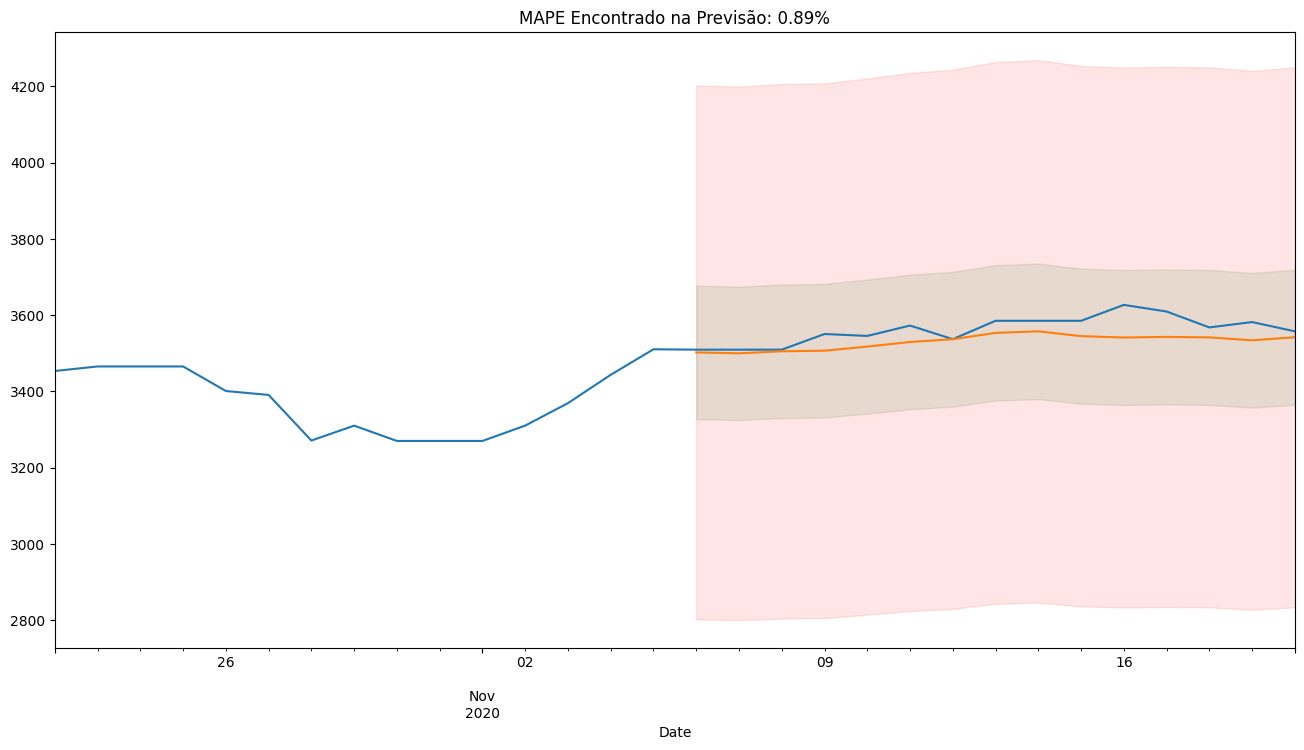

============ Melhores Parametros ============
['add', 'mul', 'mul', 'heuristic', 18]
============ Analise de Ruido ============
                                                                                                                                                                                                                                                              
Estatística Jarque-Bera : 46399.26534991293
P-valor : 0.0
Assimetria : -1.1074331014245546
Curtose : 27.704923502641797


In [6]:

'''
Aqui iniciamos a previsao utilizando o modelo ETS
'''
v_erro = ['add', 'mul']
v_trend = ['add', 'mul']
v_seasonal = ['add', 'mul']
v_init = ['estimated', 'heuristic']
v_period = [18]

best_vlerro = 99
best_para = []
best_prev = []
modelo = ''
for erro in v_erro:
    for trend in v_trend:
        for seasonal in v_seasonal:
            for init in v_init:
                for period in v_period:
                    parametros = [erro, trend, seasonal, init, period]
                    vlerro, serie_prevista, modelo = previsao_ets(serie_original, intervalo, parametros)

                    if vlerro < best_vlerro:
                        best_vlerro = vlerro
                        best_param = parametros
                        best_prev = serie_prevista

#Para uso no intervalo de confiança
x = best_prev.index
y = best_prev.values

plt.figure(figsize=(16,8))
serie_original[serie_size-2*intervalo:serie_size].plot(label=None)
best_prev.plot(label='ETS Model')
plt.fill_between(x, y*0.95, y+(y*0.05), color='g', alpha=.1)
plt.fill_between(x, y*0.8, y+(y*0.2), color='r', alpha=.1)
plt.title('MAPE Encontrado na Previsão: '+str(round(best_vlerro*100, 2))+'%')
plt.show()

print('============ Melhores Parametros ============')

print(best_param)

print('============ Analise de Ruido ============')
print(' '*254)
teste_ruido = jarque_bera(modelo.resid)
print('Estatística Jarque-Bera :', teste_ruido[0])
print('P-valor :', teste_ruido[1])
print('Assimetria :', teste_ruido[2])
print('Curtose :',teste_ruido[3])